# Facility Location: Mixed-Integer Programming

This notebook demonstrates **mixed-integer programming (MIP)** with binary decision variables, fixed costs, and Big-M constraints - a classic facility location problem.

## Problem Description

A logistics company needs to decide **which warehouses to open** and **how to route shipments** to minimize total cost. The problem involves:
- **Binary decisions**: Open a warehouse or not (triggers fixed costs)
- **Continuous decisions**: How much to ship from each warehouse to each customer
- **Conditional constraints**: Can only ship from open warehouses (Big-M)

## Mathematical Formulation

**Decision Variables:**
$$y_w \in \{0, 1\} \quad \text{open warehouse } w$$
$$x_{w,c} \geq 0 \quad \text{ship from } w \text{ to customer } c$$

**Objective (Minimize Total Cost):**
$$\min \sum_{w} \text{fixed\_cost}_w \cdot y_w + \sum_{w,c} \text{ship\_cost}_{w,c} \cdot x_{w,c}$$

**Subject to:**
$$\sum_{w} x_{w,c} \geq \text{demand}_c \quad \forall c \text{ (demand)}$$
$$\sum_{c} x_{w,c} \leq \text{capacity}_w \cdot y_w \quad \forall w \text{ (capacity)}$$
$$x_{w,c} \leq M \cdot y_w \quad \forall w,c \text{ (Big-M)}$$

## Key Concepts

- **Binary variables**: Open/close decisions
- **Fixed costs**: One-time costs for opening
- **Big-M constraints**: Conditional logic in LP
- **Multi-model indexing**: Ship indexed by `(Warehouse, Customer)`

## 1. Setup and Imports

In [1]:
# Standard library
import math
from dataclasses import dataclass
from typing import Tuple, List

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

# LumiX optimization library
from lumix import (
    LXConstraint,
    LXIndexDimension,
    LXLinearExpression,
    LXModel,
    LXOptimizer,
    LXVariable,
)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 2. Data Definition

In [2]:
@dataclass
class Warehouse:
    """Potential warehouse location with costs and capacity."""
    id: int
    name: str
    location: Tuple[float, float]  # (lat, lon)
    fixed_cost: float              # $ to open
    capacity: float                # max units


@dataclass
class Customer:
    """Customer with demand and location."""
    id: int
    name: str
    location: Tuple[float, float]  # (lat, lon)
    demand: float                  # units needed


# Sample warehouses (US cities)
WAREHOUSES = [
    Warehouse(1, "New York", (40.7128, -74.0060), 5000, 500),
    Warehouse(2, "Los Angeles", (34.0522, -118.2437), 6000, 600),
    Warehouse(3, "Dallas", (32.7767, -96.7970), 4500, 450),
    Warehouse(4, "Miami", (25.7617, -80.1918), 4000, 400),
    Warehouse(5, "Seattle", (47.6062, -122.3321), 5500, 550),
]

# Sample customers
CUSTOMERS = [
    Customer(1, "Customer 1", (40.0, -75.0), 150),
    Customer(2, "Customer 2", (34.5, -119.0), 120),
    Customer(3, "Customer 3", (41.0, -74.5), 200),
    Customer(4, "Customer 4", (33.0, -117.0), 80),
    Customer(5, "Customer 5", (32.5, -97.0), 160),
    Customer(6, "Customer 6", (48.0, -122.5), 140),
    Customer(7, "Customer 7", (26.0, -80.5), 100),
    Customer(8, "Customer 8", (47.5, -121.0), 90),
    Customer(9, "Customer 9", (33.5, -96.5), 110),
    Customer(10, "Customer 10", (40.5, -73.5), 130),
]


def haversine_distance(loc1: Tuple[float, float], loc2: Tuple[float, float]) -> float:
    """Calculate great-circle distance in miles."""
    lat1, lon1 = loc1
    lat2, lon2 = loc2
    R = 3959  # Earth radius in miles
    
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    
    a = (math.sin(dlat / 2) ** 2 + 
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) ** 2)
    c = 2 * math.asin(math.sqrt(a))
    return R * c


def shipping_cost(warehouse: Warehouse, customer: Customer) -> float:
    """Shipping cost per unit: $0.10 per 100 miles."""
    distance = haversine_distance(warehouse.location, customer.location)
    return distance * 0.001


# Big-M constant
BIG_M = sum(c.demand for c in CUSTOMERS)

print(f"Warehouses: {len(WAREHOUSES)}")
print(f"Customers: {len(CUSTOMERS)}")
print(f"Total Demand: {sum(c.demand for c in CUSTOMERS)} units")
print(f"Total Capacity: {sum(w.capacity for w in WAREHOUSES)} units")

Warehouses: 5
Customers: 10
Total Demand: 1280 units
Total Capacity: 2500 units


### Visualize the Network

In [3]:
# Create warehouse and customer DataFrames
warehouse_df = pd.DataFrame([
    {
        'Warehouse': w.name,
        'Fixed Cost ($)': w.fixed_cost,
        'Capacity': w.capacity,
        'Lat': w.location[0],
        'Lon': w.location[1]
    }
    for w in WAREHOUSES
])

print("Potential Warehouses:")
display(warehouse_df.set_index('Warehouse'))

Potential Warehouses:


,Fixed Cost ($),Capacity,Lat,Lon
Warehouse,,,,
New York,5000,500,40.7128,-74.0060
Los Angeles,6000,600,34.0522,-118.2437
Dallas,4500,450,32.7767,-96.7970
Miami,4000,400,25.7617,-80.1918
Seattle,5500,550,47.6062,-122.3321


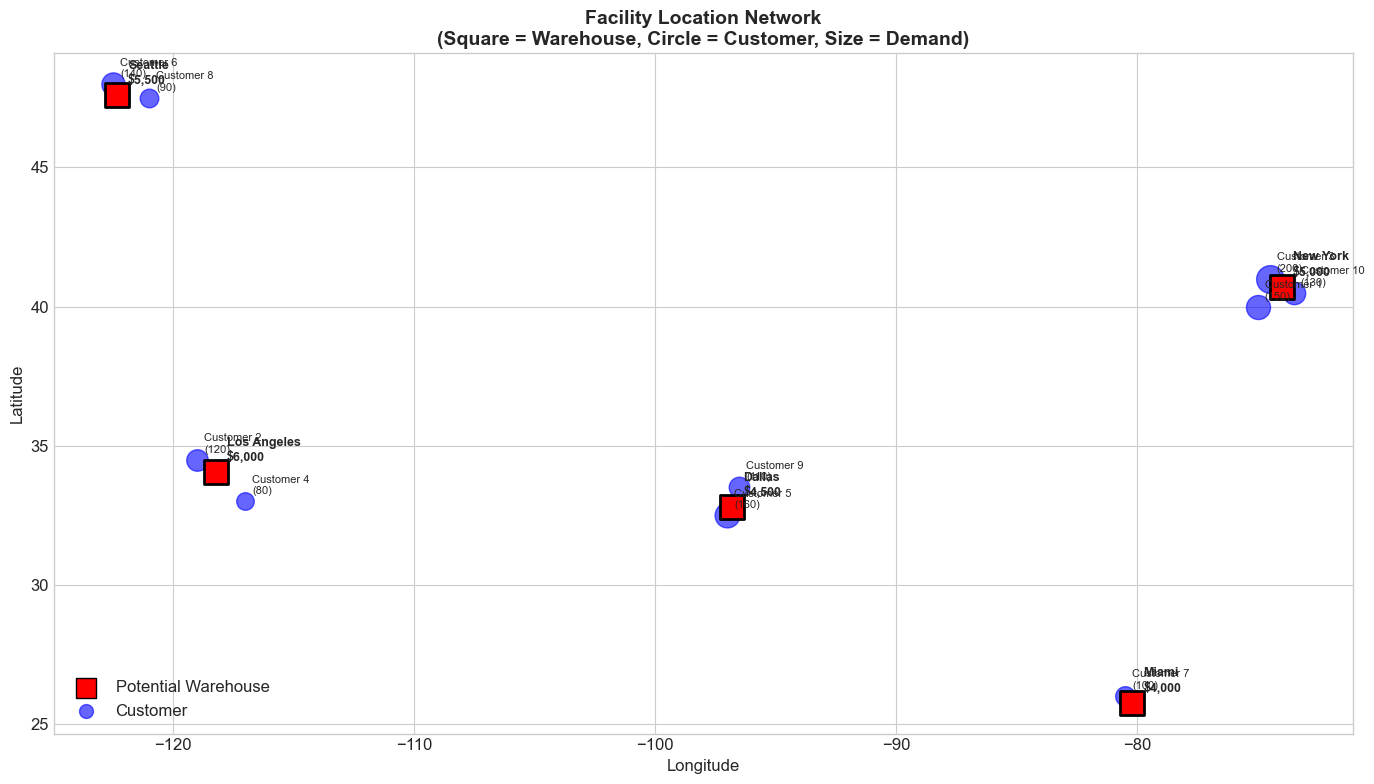

In [4]:
# Network map visualization
fig, ax = plt.subplots(figsize=(14, 8))

# Plot customers
for c in CUSTOMERS:
    ax.scatter(c.location[1], c.location[0], c='blue', s=c.demand*2, alpha=0.6, marker='o')
    ax.annotate(f'{c.name}\n({c.demand})', (c.location[1], c.location[0]), 
                textcoords='offset points', xytext=(5, 5), fontsize=8)

# Plot warehouses
for w in WAREHOUSES:
    ax.scatter(w.location[1], w.location[0], c='red', s=300, marker='s', edgecolors='black', linewidth=2)
    ax.annotate(f'{w.name}\n${w.fixed_cost:,}', (w.location[1], w.location[0]), 
                textcoords='offset points', xytext=(8, 8), fontsize=9, fontweight='bold')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Facility Location Network\n(Square = Warehouse, Circle = Customer, Size = Demand)', 
             fontsize=14, fontweight='bold')

# Legend
legend_elements = [
    plt.scatter([], [], c='red', s=200, marker='s', edgecolors='black', label='Potential Warehouse'),
    plt.scatter([], [], c='blue', s=100, marker='o', alpha=0.6, label='Customer')
]
ax.legend(handles=legend_elements, loc='lower left')

plt.tight_layout()
plt.show()

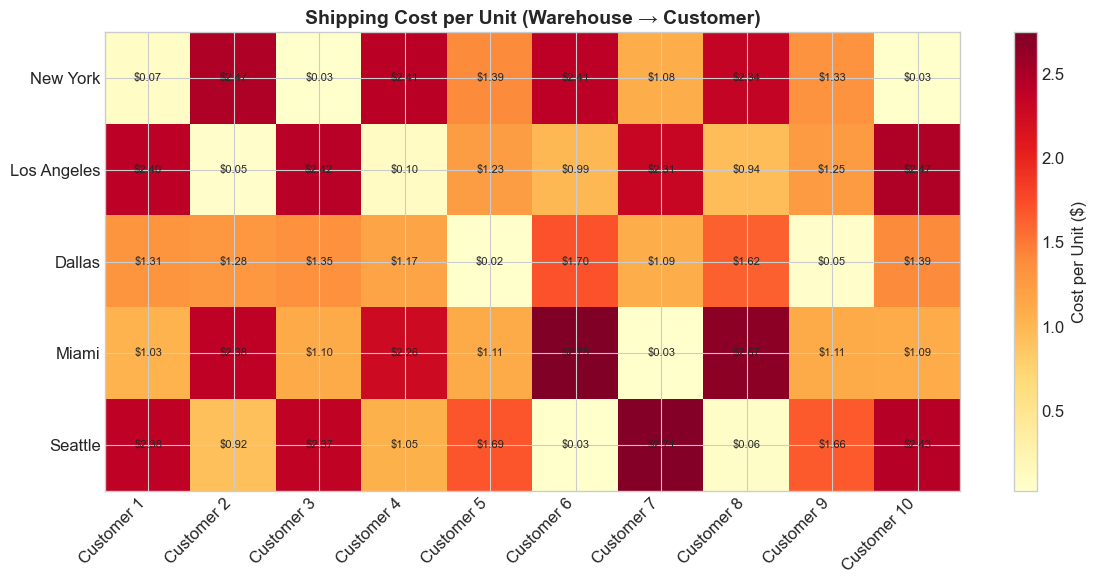

In [5]:
# Distance/cost matrix heatmap
fig, ax = plt.subplots(figsize=(12, 6))

# Create cost matrix
cost_matrix = np.array([
    [shipping_cost(w, c) for c in CUSTOMERS]
    for w in WAREHOUSES
])

im = ax.imshow(cost_matrix, cmap='YlOrRd', aspect='auto')

ax.set_xticks(np.arange(len(CUSTOMERS)))
ax.set_yticks(np.arange(len(WAREHOUSES)))
ax.set_xticklabels([c.name for c in CUSTOMERS], rotation=45, ha='right')
ax.set_yticklabels([w.name for w in WAREHOUSES])

# Add values
for i in range(len(WAREHOUSES)):
    for j in range(len(CUSTOMERS)):
        ax.text(j, i, f'${cost_matrix[i,j]:.2f}', ha='center', va='center', fontsize=8)

ax.set_title('Shipping Cost per Unit (Warehouse → Customer)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='Cost per Unit ($)')
plt.tight_layout()
plt.show()

## 3. Build the Optimization Model

In [6]:
def build_facility_location_model() -> LXModel:
    """
    Build the facility location MIP model.
    
    Features:
    - Binary variables for open/close decisions
    - Continuous variables for shipping flows
    - Big-M constraints for conditional logic
    """
    
    # Binary variable: Open warehouse or not
    open_warehouse = (
        LXVariable[Warehouse, int]("open_warehouse")
        .binary()
        .indexed_by(lambda w: w.id)
        .from_data(WAREHOUSES)
    )

    # Continuous variable: Shipping quantities (multi-indexed)
    ship = (
        LXVariable[Tuple[Warehouse, Customer], float]("ship")
        .continuous()
        .indexed_by_product(
            LXIndexDimension(Warehouse, lambda w: w.id).from_data(WAREHOUSES),
            LXIndexDimension(Customer, lambda c: c.id).from_data(CUSTOMERS),
        )
        .bounds(lower=0, upper=max(c.demand for c in CUSTOMERS))
    )

    # Create model
    model = LXModel("facility_location").add_variables(open_warehouse, ship)

    # Objective: Minimize total cost (fixed + shipping)
    cost_expr = (
        LXLinearExpression()
        .add_term(open_warehouse, coeff=lambda w: w.fixed_cost)  # Fixed costs
        .add_multi_term(ship, coeff=lambda w, c: shipping_cost(w, c))  # Shipping
    )
    model.minimize(cost_expr)

    # Constraint 1: Satisfy customer demand
    for customer in CUSTOMERS:
        demand_expr = LXLinearExpression().add_multi_term(
            ship,
            coeff=lambda w, c: 1.0,
            where=lambda w, c, cust=customer: c.id == cust.id,
        )
        model.add_constraint(
            LXConstraint(f"demand_{customer.name}")
            .expression(demand_expr)
            .ge()
            .rhs(customer.demand)
        )

    # Constraint 2: Warehouse capacity (only if open)
    for warehouse in WAREHOUSES:
        capacity_expr = (
            LXLinearExpression()
            .add_multi_term(
                ship,
                coeff=lambda w, c: 1.0,
                where=lambda w, c, wh=warehouse: w.id == wh.id,
            )
            .add_term(
                open_warehouse,
                coeff=lambda w, wh=warehouse: -wh.capacity if w.id == wh.id else 0,
            )
        )
        model.add_constraint(
            LXConstraint(f"capacity_{warehouse.name}")
            .expression(capacity_expr)
            .le()
            .rhs(0)
        )

    # Constraint 3: Big-M - Can only ship from open warehouses
    for warehouse in WAREHOUSES:
        for customer in CUSTOMERS:
            bigm_expr = (
                LXLinearExpression()
                .add_multi_term(
                    ship,
                    coeff=lambda w, c: 1.0,
                    where=lambda w, c, wh=warehouse, cu=customer: w.id == wh.id and c.id == cu.id,
                )
                .add_term(
                    open_warehouse,
                    coeff=lambda w, wh=warehouse: -BIG_M if w.id == wh.id else 0,
                )
            )
            model.add_constraint(
                LXConstraint(f"bigm_{warehouse.name}_{customer.name}")
                .expression(bigm_expr)
                .le()
                .rhs(0)
            )

    return model


# Build the model
model = build_facility_location_model()

print("Model Summary:")
print("=" * 50)
print(model.summary())

Model Summary:
LXModel: facility_location
  Variable Families: 2
  Constraint Families: 65
  Objective: min



## 4. Solve the Model

In [7]:
# Create optimizer
optimizer = LXOptimizer().use_solver("ortools")

# Solve
print("Solving the facility location problem...")
solution = optimizer.solve(model)

print(f"\nSolution Status: {solution.status}")
print(f"Total Cost: ${solution.objective_value:,.2f}")
print(f"Solve Time: {solution.solve_time:.3f}s")

2025-12-12 16:54:21 - lumix.optimizer - INFO - Created model 'facility_location' with 2 variables and 65 constraints
2025-12-12 16:54:21 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 16:54:21 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 14419.8921 | Time: 0.06s


Solving the facility location problem...

Solution Status: optimal
Total Cost: $14,419.89
Solve Time: 0.054s


## 5. Analyze the Results

In [8]:
# Extract which warehouses are open
open_warehouses = []
closed_warehouses = []
fixed_cost_total = 0

for warehouse in WAREHOUSES:
    is_open = solution.variables["open_warehouse"][warehouse.id] > 0.5
    if is_open:
        open_warehouses.append(warehouse)
        fixed_cost_total += warehouse.fixed_cost
    else:
        closed_warehouses.append(warehouse)

shipping_cost_total = solution.objective_value - fixed_cost_total

print("\n" + "=" * 70)
print("FACILITY DECISIONS")
print("=" * 70)
print(f"\nOpen Warehouses ({len(open_warehouses)}):")
for w in open_warehouses:
    print(f"  - {w.name}: Fixed Cost ${w.fixed_cost:,}")

print(f"\nClosed Warehouses ({len(closed_warehouses)}):")
for w in closed_warehouses:
    print(f"  - {w.name}")

print(f"\n" + "-" * 70)
print(f"Fixed Costs:    ${fixed_cost_total:,.2f}")
print(f"Shipping Costs: ${shipping_cost_total:,.2f}")
print(f"Total Cost:     ${solution.objective_value:,.2f}")


FACILITY DECISIONS

Open Warehouses (3):
  - New York: Fixed Cost $5,000
  - Dallas: Fixed Cost $4,500
  - Miami: Fixed Cost $4,000

Closed Warehouses (2):
  - Los Angeles
  - Seattle

----------------------------------------------------------------------
Fixed Costs:    $13,500.00
Shipping Costs: $919.89
Total Cost:     $14,419.89


In [9]:
# Extract shipping flows
flows = []
for warehouse in WAREHOUSES:
    is_open = solution.variables["open_warehouse"][warehouse.id] > 0.5
    if not is_open:
        continue
    
    for customer in CUSTOMERS:
        qty = solution.variables["ship"].get((warehouse.id, customer.id), 0)
        if qty > 0.01:
            cost = shipping_cost(warehouse, customer) * qty
            flows.append({
                'From': warehouse.name,
                'To': customer.name,
                'Quantity': qty,
                'Cost ($)': cost
            })

flows_df = pd.DataFrame(flows)

print("\n" + "=" * 70)
print("SHIPPING PLAN")
print("=" * 70)
display(flows_df.round(2))


SHIPPING PLAN


,From,To,Quantity,Cost ($)
0,New York,Customer 1,150.0,10.78
1,New York,Customer 3,200.0,6.51
2,New York,Customer 6,20.0,48.13
3,New York,Customer 10,130.0,3.94
4,Dallas,Customer 2,120.0,153.63
5,Dallas,Customer 4,80.0,93.64
6,Dallas,Customer 5,160.0,3.60
7,Dallas,Customer 9,90.0,4.76
8,Miami,Customer 6,120.0,329.73
9,Miami,Customer 7,100.0,2.53


In [10]:
# Warehouse utilization
utilization_data = []
for warehouse in open_warehouses:
    shipped = sum(
        solution.variables["ship"].get((warehouse.id, c.id), 0)
        for c in CUSTOMERS
    )
    customers_served = sum(
        1 for c in CUSTOMERS
        if solution.variables["ship"].get((warehouse.id, c.id), 0) > 0.01
    )
    utilization_data.append({
        'Warehouse': warehouse.name,
        'Shipped': shipped,
        'Capacity': warehouse.capacity,
        'Utilization (%)': (shipped / warehouse.capacity) * 100,
        'Customers Served': customers_served
    })

util_df = pd.DataFrame(utilization_data)

print("\n" + "=" * 70)
print("WAREHOUSE UTILIZATION")
print("=" * 70)
display(util_df.round(2).set_index('Warehouse'))


WAREHOUSE UTILIZATION


,Shipped,Capacity,Utilization (%),Customers Served
Warehouse,,,,
New York,500.0,500,100.0,4
Dallas,450.0,450,100.0,4
Miami,330.0,400,82.5,4


## 6. Visualize the Optimal Solution

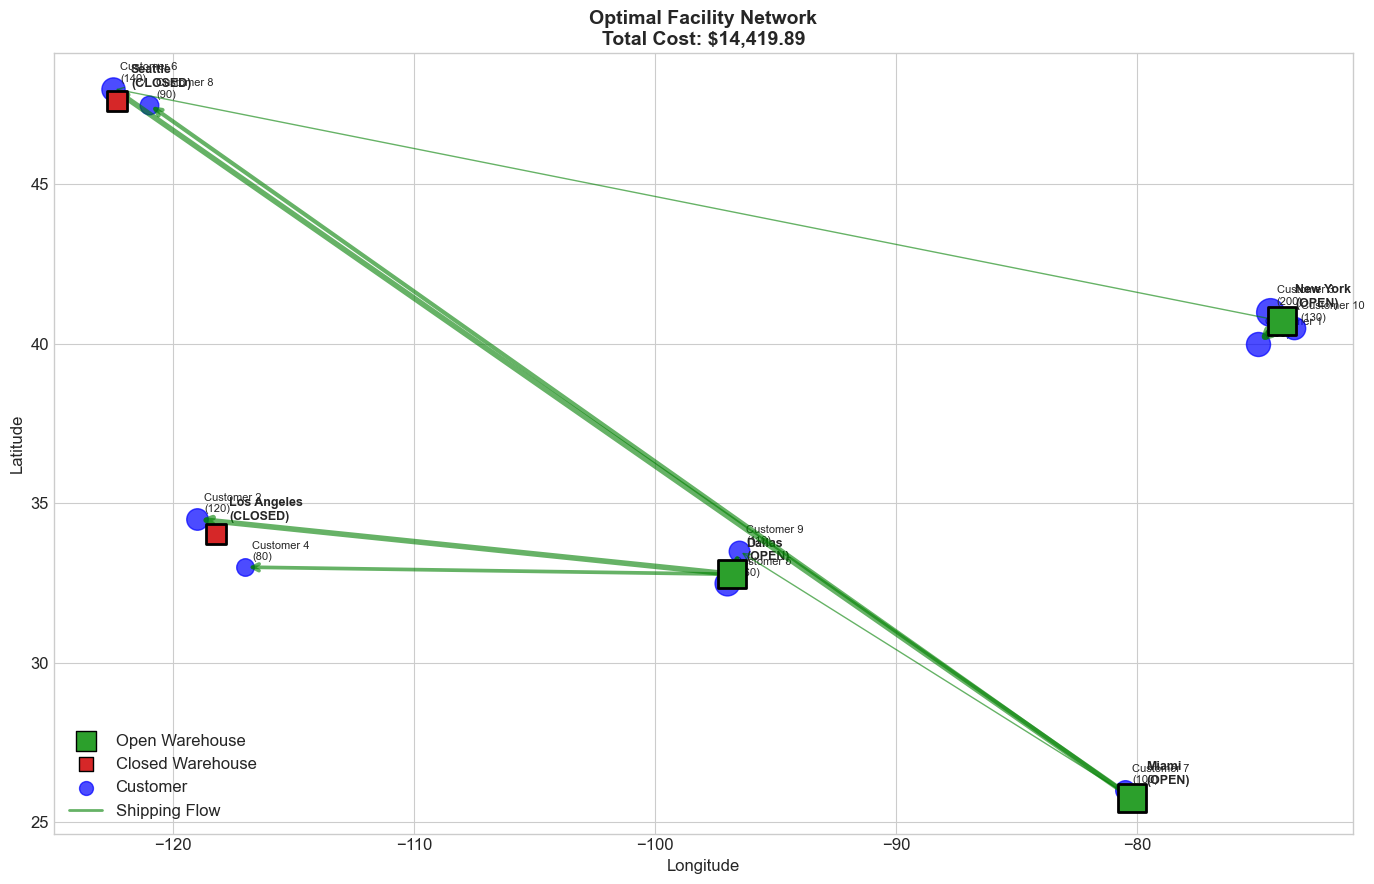

In [11]:
# Network visualization with optimal flows
fig, ax = plt.subplots(figsize=(14, 9))

# Plot customers
for c in CUSTOMERS:
    ax.scatter(c.location[1], c.location[0], c='blue', s=c.demand*2, alpha=0.7, marker='o', zorder=3)
    ax.annotate(f'{c.name}\n({c.demand})', (c.location[1], c.location[0]), 
                textcoords='offset points', xytext=(5, 5), fontsize=8)

# Plot warehouses (different colors for open/closed)
for w in WAREHOUSES:
    is_open = w in open_warehouses
    color = '#2ca02c' if is_open else '#d62728'
    marker_size = 400 if is_open else 200
    ax.scatter(w.location[1], w.location[0], c=color, s=marker_size, marker='s', 
               edgecolors='black', linewidth=2, zorder=4)
    status = 'OPEN' if is_open else 'CLOSED'
    ax.annotate(f'{w.name}\n({status})', (w.location[1], w.location[0]), 
                textcoords='offset points', xytext=(10, 10), fontsize=9, fontweight='bold')

# Draw shipping flows
for _, flow in flows_df.iterrows():
    w = next(w for w in WAREHOUSES if w.name == flow['From'])
    c = next(c for c in CUSTOMERS if c.name == flow['To'])
    
    # Line thickness based on quantity
    linewidth = max(1, flow['Quantity'] / 30)
    ax.annotate('', xy=(c.location[1], c.location[0]), xytext=(w.location[1], w.location[0]),
                arrowprops=dict(arrowstyle='->', color='green', alpha=0.6, lw=linewidth))

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Optimal Facility Network\nTotal Cost: ${solution.objective_value:,.2f}', 
             fontsize=14, fontweight='bold')

# Legend
legend_elements = [
    plt.scatter([], [], c='#2ca02c', s=200, marker='s', edgecolors='black', label='Open Warehouse'),
    plt.scatter([], [], c='#d62728', s=100, marker='s', edgecolors='black', label='Closed Warehouse'),
    plt.scatter([], [], c='blue', s=100, marker='o', alpha=0.7, label='Customer'),
    plt.Line2D([0], [0], color='green', alpha=0.6, linewidth=2, label='Shipping Flow')
]
ax.legend(handles=legend_elements, loc='lower left')

plt.tight_layout()
plt.show()

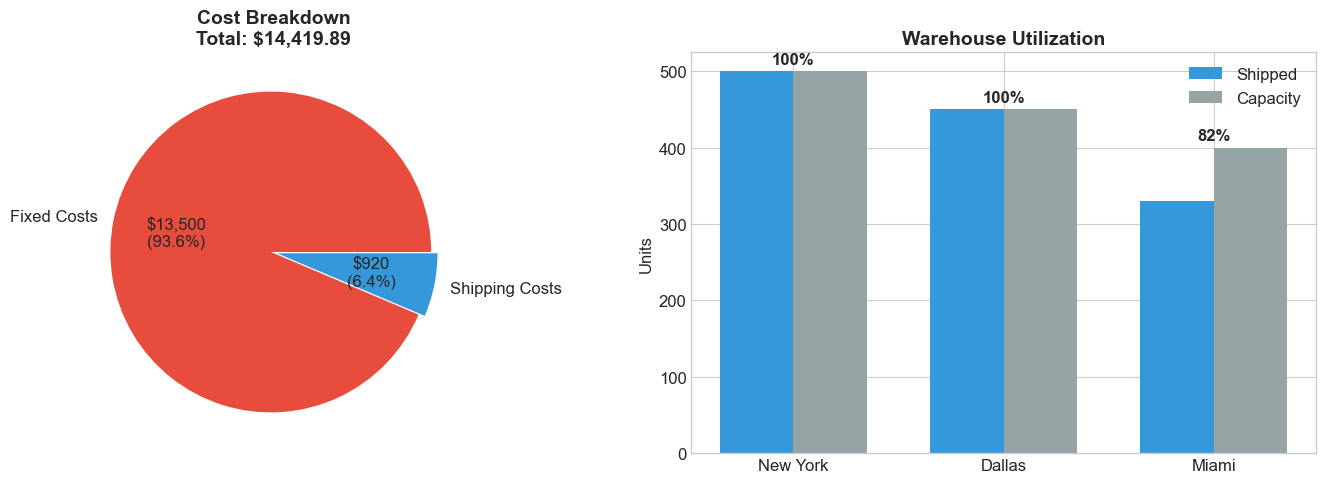

In [12]:
# Cost breakdown visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fixed vs Variable costs
ax1 = axes[0]
costs = [fixed_cost_total, shipping_cost_total]
labels = ['Fixed Costs', 'Shipping Costs']
colors = ['#e74c3c', '#3498db']

wedges, texts, autotexts = ax1.pie(
    costs, labels=labels, autopct=lambda pct: f'${pct/100*solution.objective_value:,.0f}\n({pct:.1f}%)',
    colors=colors, explode=[0.02, 0.02]
)
ax1.set_title(f'Cost Breakdown\nTotal: ${solution.objective_value:,.2f}', fontsize=14, fontweight='bold')

# Warehouse utilization bars
ax2 = axes[1]
if len(util_df) > 0:
    x = np.arange(len(util_df))
    width = 0.35
    
    bars1 = ax2.bar(x - width/2, util_df['Shipped'], width, label='Shipped', color='#3498db')
    bars2 = ax2.bar(x + width/2, util_df['Capacity'], width, label='Capacity', color='#95a5a6')
    
    ax2.set_ylabel('Units')
    ax2.set_title('Warehouse Utilization', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(util_df['Warehouse'])
    ax2.legend()
    
    # Add utilization percentage
    for i, pct in enumerate(util_df['Utilization (%)']):
        ax2.annotate(f'{pct:.0f}%', (i, max(util_df['Shipped'].iloc[i], util_df['Capacity'].iloc[i]) + 10),
                     ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

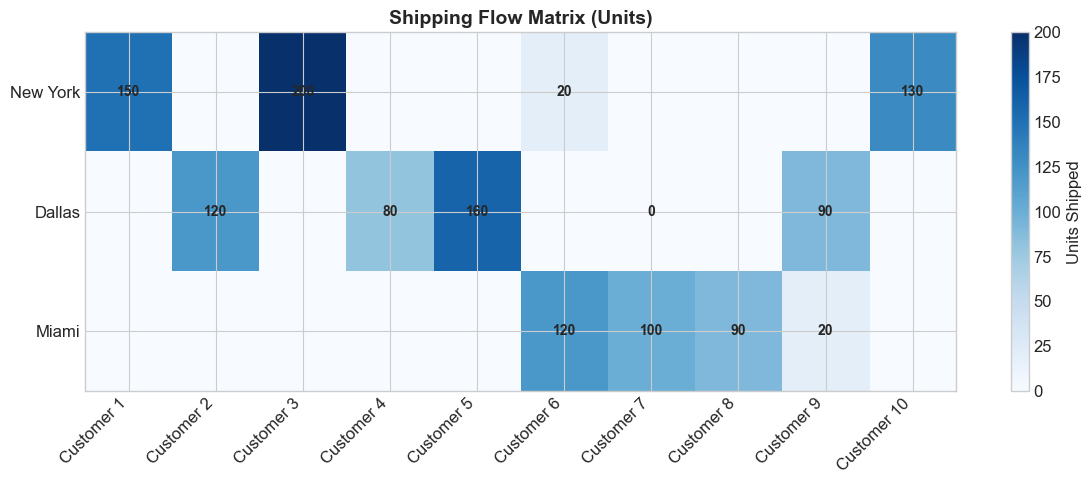

In [13]:
# Flow matrix heatmap
fig, ax = plt.subplots(figsize=(12, 5))

# Create flow matrix (only for open warehouses)
flow_matrix = np.zeros((len(open_warehouses), len(CUSTOMERS)))

for i, w in enumerate(open_warehouses):
    for j, c in enumerate(CUSTOMERS):
        flow_matrix[i, j] = solution.variables["ship"].get((w.id, c.id), 0)

im = ax.imshow(flow_matrix, cmap='Blues', aspect='auto')

ax.set_xticks(np.arange(len(CUSTOMERS)))
ax.set_yticks(np.arange(len(open_warehouses)))
ax.set_xticklabels([c.name for c in CUSTOMERS], rotation=45, ha='right')
ax.set_yticklabels([w.name for w in open_warehouses])

# Add values
for i in range(len(open_warehouses)):
    for j in range(len(CUSTOMERS)):
        val = flow_matrix[i, j]
        if val > 0:
            ax.text(j, i, f'{val:.0f}', ha='center', va='center', fontsize=10, fontweight='bold')

ax.set_title('Shipping Flow Matrix (Units)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='Units Shipped')
plt.tight_layout()
plt.show()

## 7. Key Insights

### What We Learned

1. **Binary Variables**: `open_warehouse` is binary (0 or 1) - either open or closed

2. **Fixed Costs**: Only incurred when `open_warehouse = 1` - this creates a trade-off between:
   - Opening more facilities (higher fixed cost, lower shipping)
   - Opening fewer facilities (lower fixed cost, higher shipping)

3. **Big-M Constraints**: The constraint `ship[w,c] <= M × open[w]` ensures:
   - If warehouse is closed (`open[w]=0`): `ship[w,c] <= 0` (no shipping)
   - If warehouse is open (`open[w]=1`): `ship[w,c] <= M` (effectively unconstrained)

4. **Mixed-Integer Programming**: Combining binary (open/close) and continuous (shipping) variables

### Business Insights

The optimal solution balances fixed costs against shipping costs. Opening more warehouses reduces average shipping distance but increases fixed costs.

## 8. Extensions & Exercises

1. **Minimum warehouses**: Require at least 2 warehouses to be open
2. **Maximum warehouses**: Limit to opening at most 3 warehouses
3. **Service level**: Each customer must be served by at least 2 warehouses
4. **Transportation modes**: Add different shipping options (ground, air)
5. **Multi-period**: Plan expansion over multiple years